# <center>Detección De Neumonía Utilizando Redes Convolucionales Y Transfer Learning</center>
<center>AMÉRICA VICTORIA RAMÍREZ CÁMARA</center>
<center><em>Facultad de Ciencias Físico Matemáticas</em></center>
<center><em>Universidad Autónoma de Nuevo León</em></center>
<center>Nuevo León, México</center>
<center>america.ramirezcm@uanl.edu.mx</center>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
import os
from tensorflow.keras import layers, optimizers

In [2]:
batch_size = 128
epochs = 35
image_size = (300,300)
test_size = 0.2

## Load Data And Division Of Data

In [3]:
training_images = tf.io.gfile.glob('C:/Users/ameri/OneDrive/Documents/MCD/Tetramestre 4/Preprocesamiento de datos/Proyecto Final/chest_xray/train/*/*')
validation_images = tf.io.gfile.glob('C:/Users/ameri/OneDrive/Documents/MCD/Tetramestre 4/Preprocesamiento de datos/Proyecto Final/chest_xray/val/*/*')

print(f'Before division of 80:20')
print(f'Total number of training images = {len(training_images)}')
print(f'Total number of validation images = {len(validation_images)}\n')


total_files = training_images
total_files.extend(validation_images)
print(f'Total number of images : training_images + validation_images = {len(total_files)}\n')

train_images, val_images = train_test_split(total_files, test_size = test_size)
print(f'After division of 80:20')
print(f'Total number of training images = {len(train_images)}')
print(f'Total number of validation images = {len(val_images)}')

Before division of 80:20
Total number of training images = 5216
Total number of validation images = 16

Total number of images : training_images + validation_images = 5232

After division of 80:20
Total number of training images = 4185
Total number of validation images = 1047


Normal images count in training set: 1070
Pneumonia images count in training set: 3115


C:\Users\ameri\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

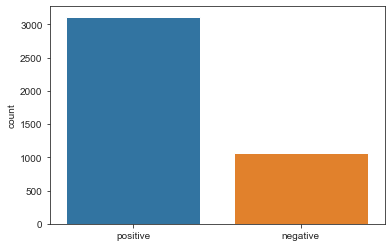

In [4]:
count_normal = len([x for x in train_images if "NORMAL" in x])
print(f'Normal images count in training set: {count_normal}')

count_pneumonia = len([x for x in train_images if "PNEUMONIA" in x])
print(f'Pneumonia images count in training set: {count_pneumonia}')

count_array = []
count_array += ['positive']*count_pneumonia
count_array += ['negative']*count_normal

sns.set_style('ticks')
sns.countplot(count_array)

In [5]:
train_datagen = ImageDataGenerator(rescale = 1/255,
                                 rotation_range = 30,
                                 zoom_range = 0.2,
                                 width_shift_range = 0.1,
                                 height_shift_range = 0.1)
val_datagen = ImageDataGenerator(rescale = 1/255)
                                

train_generator = train_datagen.flow_from_directory(
    'C:/Users/ameri/OneDrive/Documents/MCD/Tetramestre 4/Preprocesamiento de datos/Proyecto Final/chest_xray/train_dataset/',
    target_size = image_size,
    batch_size = batch_size ,
    class_mode = 'binary'
)

validation_generator = val_datagen.flow_from_directory(
    'C:/Users/ameri/OneDrive/Documents/MCD/Tetramestre 4/Preprocesamiento de datos/Proyecto Final/chest_xray/val_dataset/',
    target_size = image_size,
    batch_size = batch_size ,
    class_mode = 'binary'
)

Found 4185 images belonging to 2 classes.
Found 1047 images belonging to 2 classes.


In [6]:
eval_datagen = ImageDataGenerator(rescale = 1/255)

test_generator = eval_datagen.flow_from_directory(
    'C:/Users/ameri/OneDrive/Documents/MCD/Tetramestre 4/Preprocesamiento de datos/Proyecto Final/chest_xray/test',
    target_size = image_size,
    batch_size = batch_size , 
    class_mode = 'binary'
)

Found 624 images belonging to 2 classes.


## Correction For Data Imbalance

In [7]:
initial_bias = np.log([count_pneumonia/count_normal])
initial_bias

array([1.0685705])

In [8]:
weight_for_0 = (1 / count_normal)*(len(train_images))/2.0 
weight_for_1 = (1 / count_pneumonia)*(len(train_images))/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.96
Weight for class 1: 0.67


## CNN Model

In [9]:
model = Sequential()
model.add(Conv2D(32, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (300,300,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(128, (3,3), strides = 1, padding = 'same', activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(256, (3,3), strides = 1, padding = 'same', activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = "rmsprop", loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 300, 300, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 64)        0

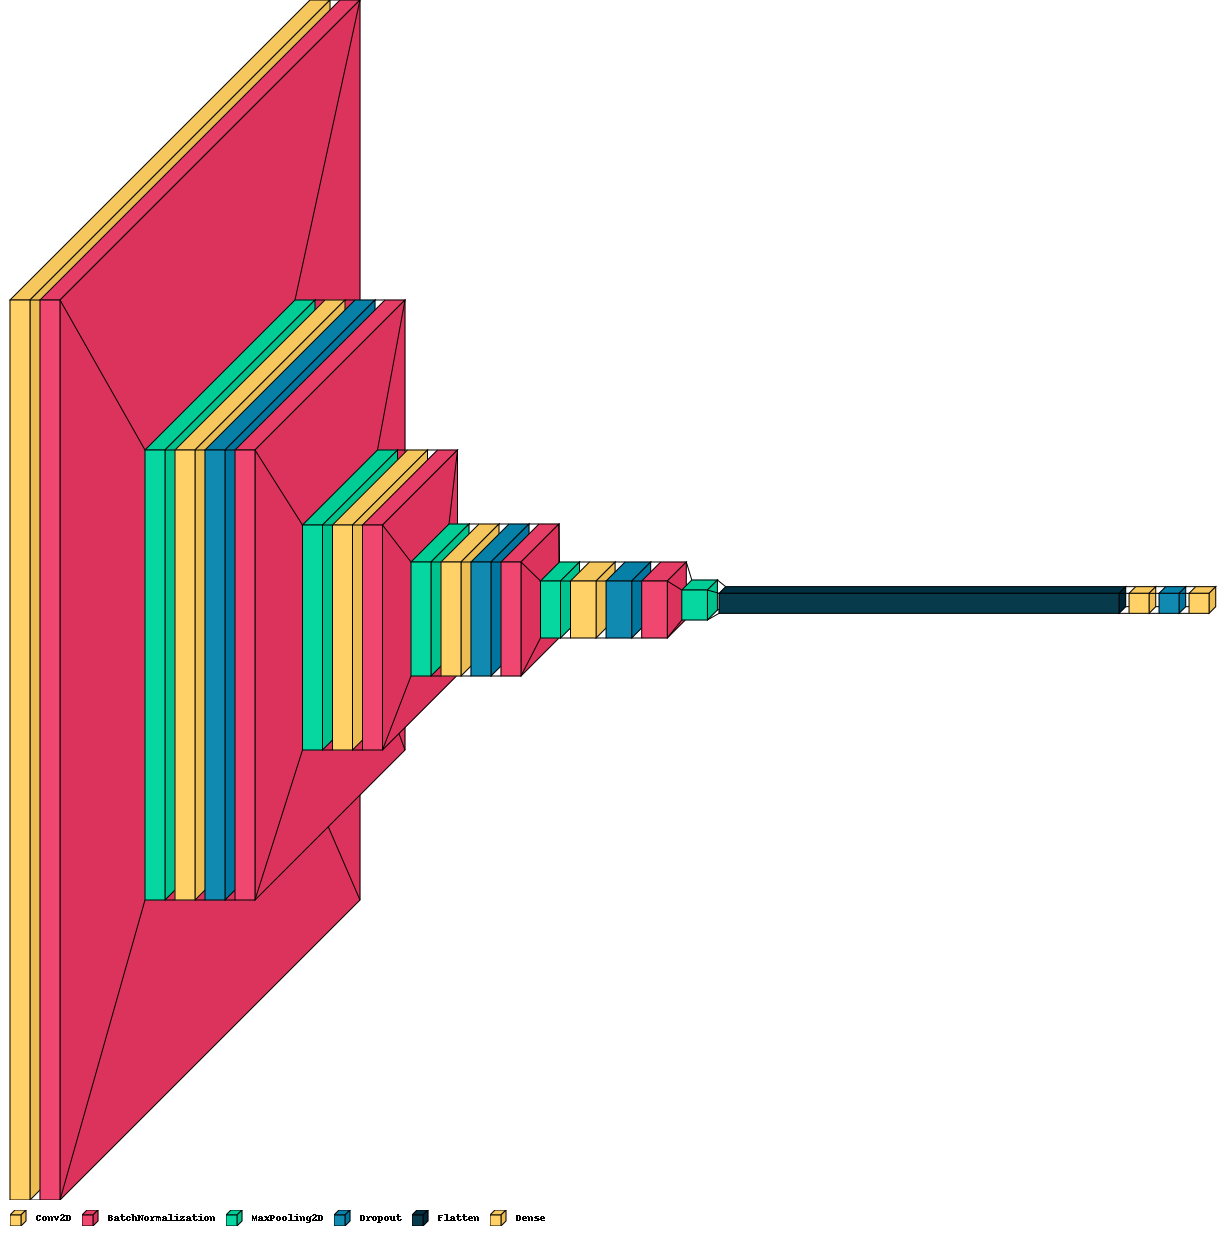

In [10]:
import visualkeras
visualkeras.layered_view(model, scale_xy = 3, legend = True,)

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 2, verbose = 1, factor = 0.3, min_lr = 0.000001)

### Train The Model

In [12]:
history = model.fit(train_generator, epochs = 12, validation_data = validation_generator, class_weight = class_weight, callbacks = [learning_rate_reduction])

Epoch 1/12
33/33 [==============================] - 1972s 60s/step - loss: 3.4664 - accuracy: 0.8127 - val_loss: 3.3336 - val_accuracy: 0.7383
Epoch 2/12
33/33 [==============================] - 1339s 41s/step - loss: 0.3506 - accuracy: 0.8562 - val_loss: 1.1450 - val_accuracy: 0.7383
Epoch 3/12
33/33 [==============================] - 1419s 43s/step - loss: 0.3619 - accuracy: 0.8683 - val_loss: 2.8666 - val_accuracy: 0.7383
Epoch 4/12
33/33 [==============================] - ETA: 0s - loss: 0.3184 - accuracy: 0.8915 
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
33/33 [==============================] - 1317s 40s/step - loss: 0.3184 - accuracy: 0.8915 - val_loss: 3.9144 - val_accuracy: 0.7383
Epoch 5/12
33/33 [==============================] - 1360s 41s/step - loss: 0.2016 - accuracy: 0.9211 - val_loss: 3.5334 - val_accuracy: 0.7383
Epoch 6/12
33/33 [==============================] - ETA: 0s - loss: 0.1598 - accuracy: 0.9376 
Epoch 00006: ReduceLROnPla

### Visualise The Model Performance

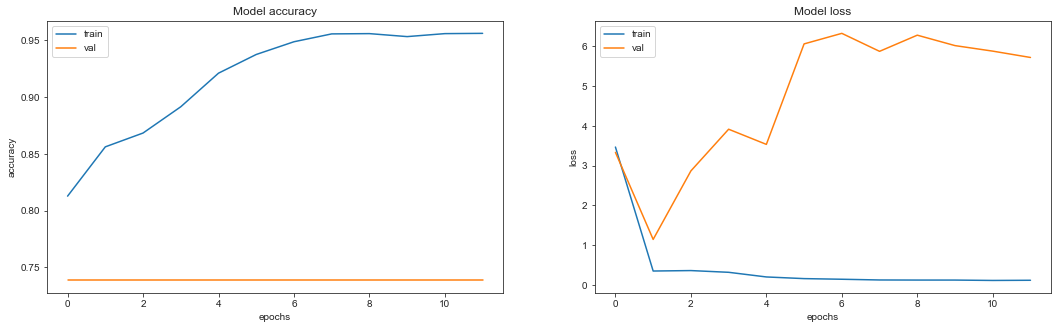

In [13]:
figure, axis = plt.subplots(1, 2, figsize=(18,5))
axis = axis.ravel()

for i,element in enumerate(['accuracy', 'loss']):
    axis[i].plot(history.history[element])
    axis[i].plot(history.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('epochs')
    axis[i].set_ylabel(element)
    axis[i].legend(['train', 'val'])

### Predict And Evaluate On Test Dataset

In [14]:
eval_result1 = model.evaluate_generator(test_generator, 624)
print('loss rate at evaluation data :', eval_result1[0])
print('accuracy rate at evaluation data :', eval_result1[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.
loss rate at evaluation data : 9.311220169067383
accuracy rate at evaluation data : 0.625


In [15]:
predictions = model.predict_classes(test_generator)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [16]:
print(classification_report(test_generator.classes, predictions, target_names = ['Pneumonia (Class 1)','Normal (Class 0)']))

                     precision    recall  f1-score   support

Pneumonia (Class 1)       0.00      0.00      0.00       234
   Normal (Class 0)       0.62      1.00      0.77       390

           accuracy                           0.62       624
          macro avg       0.31      0.50      0.38       624
       weighted avg       0.39      0.62      0.48       624



C:\Users\ameri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ameri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ameri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
cm = confusion_matrix(test_generator.classes, predictions)
cm

array([[  0, 234],
       [  0, 390]], dtype=int64)

In [18]:
cm = pd.DataFrame(cm, index = ['0','1'], columns = ['0','1'])

<AxesSubplot:>

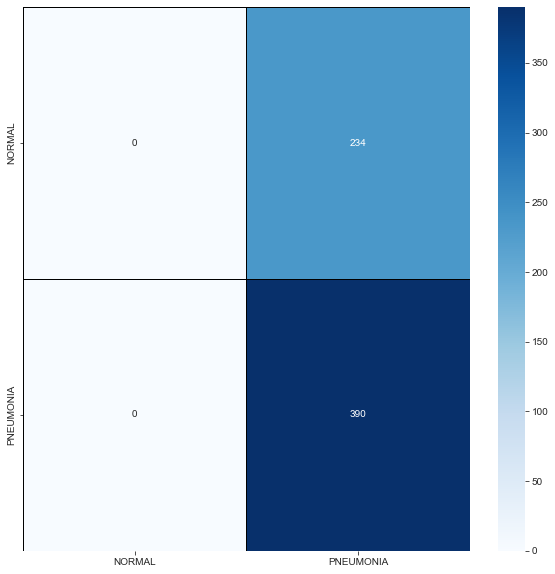

In [19]:
labels = ['NORMAL', 'PNEUMONIA']
plt.figure(figsize = (10,10))
sns.heatmap(cm, cmap = "Blues", linecolor = 'black', linewidth = 1, annot = True, fmt = '', xticklabels = labels, yticklabels = labels)

In [20]:
correct = np.nonzero(predictions == test_generator.classes)[0]
incorrect = np.nonzero(predictions != test_generator.classes)[0]

### Images On Which Output Predicted Incorrectly By Model

wrong_prediction_by_model --- 1


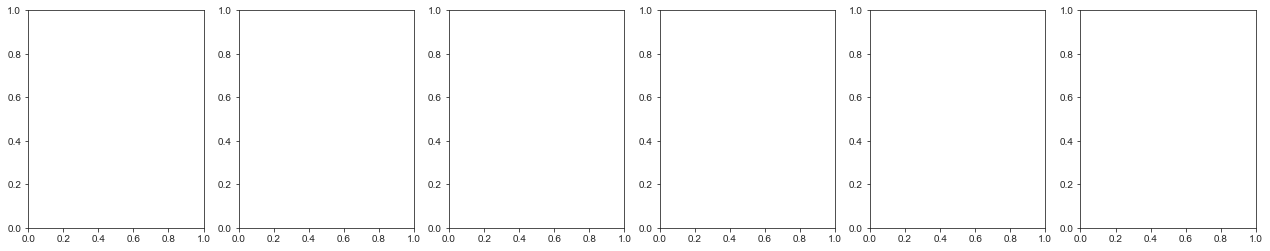

In [21]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 22,4
fig, ax = plt.subplots(1,6)

i = 0
for ele in incorrect[:0]:
    image = tf.keras.preprocessing.image.array_to_img(ele.reshape(300,300,3))
    ax[i].imshow(image)
    i += 1

print(f'wrong_prediction_by_model --- {incorrect[1]}')

### Images On Which Output Predicted Correctly By Model

correct_prediction_by_model --- 235


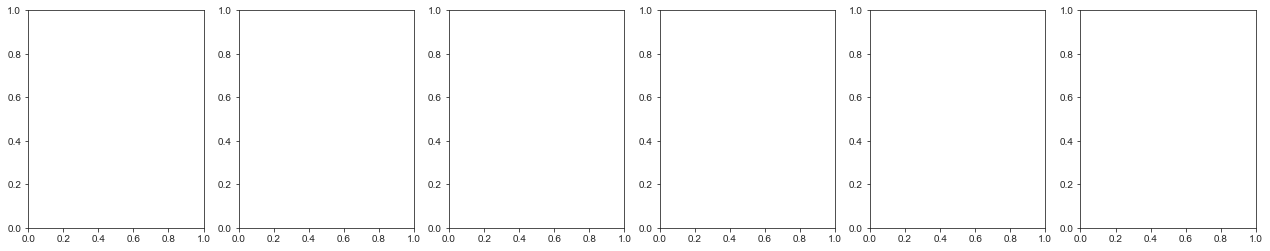

In [22]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 22,4
fig, ax = plt.subplots(1,6)

i = 0
for ele in correct[:0]:
    image = tf.keras.preprocessing.image.array_to_img(ele.reshape(300,300,3))
    ax[i].imshow(image)
    i += 1

print(f'correct_prediction_by_model --- {correct[1]}')

## Inception Net Model

In [23]:
base_model2 = tf.keras.applications.InceptionV3(input_shape = (300, 300, 3), include_top = False, weights = 'imagenet')

for layers in base_model2.layers[:200]:
    layers.trainable = False

model2 = tf.keras.Sequential([
        base_model2,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1, activation = tf.nn.sigmoid) 
        ])

model2.compile(loss = 'binary_crossentropy', optimizer = RMSprop(lr = 0.001), metrics = ['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 14,806,337
Non-trainable params: 6,998,496
_________________________________________________________________


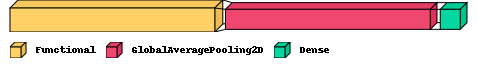

In [24]:
import visualkeras
visualkeras.layered_view(model2, scale_xy = 3, legend = True,)

In [25]:
checkpoint_cb2 = tf.keras.callbacks.ModelCheckpoint("model1_inceptionNet.h5",
                                                    save_best_only = True)

early_stopping_cb2 = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min', restore_best_weights = True)
     

### Train The Model

In [26]:
history2 = model2.fit(
    train_generator,
    steps_per_epoch = 10,
    epochs = epochs,
    validation_data = validation_generator,
    class_weight = class_weight,
    callbacks = [checkpoint_cb2, early_stopping_cb2]    
)

Epoch 1/35
10/10 [==============================] - 227s 23s/step - loss: 0.6204 - accuracy: 0.8047 - val_loss: 2.0066 - val_accuracy: 0.8701
Epoch 2/35
10/10 [==============================] - 226s 23s/step - loss: 0.1127 - accuracy: 0.9563 - val_loss: 2.8255 - val_accuracy: 0.8223
Epoch 3/35
10/10 [==============================] - 225s 22s/step - loss: 0.0946 - accuracy: 0.9678 - val_loss: 5.8045 - val_accuracy: 0.4651
Epoch 4/35
10/10 [==============================] - 228s 23s/step - loss: 0.0885 - accuracy: 0.9742 - val_loss: 0.2725 - val_accuracy: 0.9427
Epoch 5/35
10/10 [==============================] - 217s 22s/step - loss: 0.0613 - accuracy: 0.9766 - val_loss: 1.2956 - val_accuracy: 0.8453
Epoch 6/35
10/10 [==============================] - 220s 22s/step - loss: 0.0763 - accuracy: 0.9734 - val_loss: 0.6245 - val_accuracy: 0.9284
Epoch 7/35
10/10 [==============================] - 223s 22s/step - loss: 0.0704 - accuracy: 0.9750 - val_loss: 2.5115 - val_accuracy: 0.7937
Epoch 

### Visualise The Model Performance

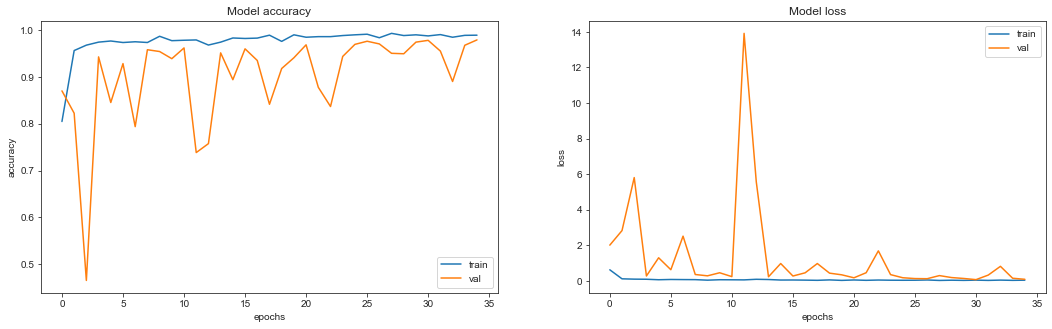

In [27]:
figure, axis = plt.subplots(1, 2, figsize = (18,5))
axis = axis.ravel()

for i,element in enumerate(['accuracy', 'loss']):
    axis[i].plot(history2.history[element])
    axis[i].plot(history2.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('epochs')
    axis[i].set_ylabel(element)
    axis[i].legend(['train', 'val'])

### Predict And Evaluate On Test Dataset

In [28]:
eval_result2 = model2.evaluate_generator(test_generator, 624)
print('loss rate at evaluation data :', eval_result2[0])
print('accuracy rate at evaluation data :', eval_result2[1])

loss rate at evaluation data : 0.9154806137084961
accuracy rate at evaluation data : 0.8685897588729858


In [29]:
predictions = model2.predict_classes(test_generator)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1])

In [30]:
print(classification_report(test_generator.classes, predictions, target_names = ['Pneumonia (Class 1)','Normal (Class 0)']))

                     precision    recall  f1-score   support

Pneumonia (Class 1)       0.34      0.22      0.27       234
   Normal (Class 0)       0.61      0.74      0.67       390

           accuracy                           0.55       624
          macro avg       0.48      0.48      0.47       624
       weighted avg       0.51      0.55      0.52       624



In [31]:
cm = confusion_matrix(test_generator.classes, predictions)
cm

array([[ 52, 182],
       [100, 290]], dtype=int64)

In [32]:
cm = pd.DataFrame(cm , index = ['0','1'], columns = ['0','1'])

<AxesSubplot:>

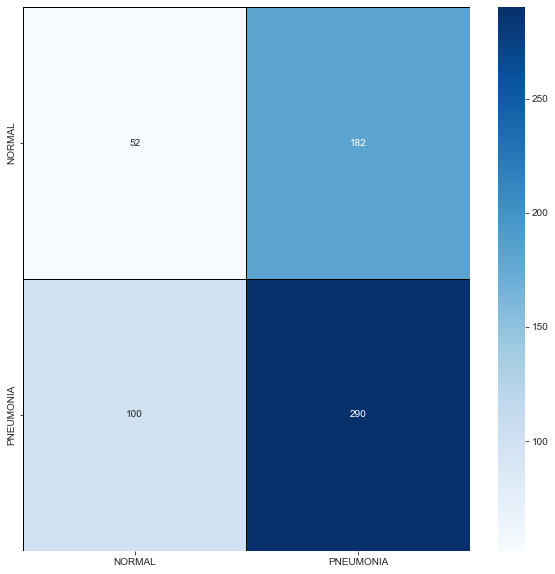

In [33]:
labels = ['NORMAL', 'PNEUMONIA']
plt.figure(figsize = (10,10))
sns.heatmap(cm, cmap = "Blues", linecolor = 'black', linewidth = 1, annot = True, fmt = '', xticklabels = labels, yticklabels = labels)

In [34]:
model2.save('C:/Users/ameri/OneDrive/Documents/MCD/Tetramestre 4/Preprocesamiento de datos/Proyecto Final/')
Inception_model = tf.keras.models.load_model('C:/Users/ameri/OneDrive/Documents/MCD/Tetramestre 4/Preprocesamiento de datos/Proyecto Final/model1_inceptionNet.h5')

wrong_predicted_image = [[],[]]
correct_predicted_image = [[],[]]
i = 0
while i< 5 and len(wrong_predicted_image[0]) < 6:
    j = 0
    while j < 128 and len(wrong_predicted_image[0]) < 6:
        
        image_array = (test_generator[i][0][j]).reshape(1,300,300,3)
        
        prediction = Inception_model.predict(image_array)
        
        if int(round(prediction[0][0])) != test_generator[i][1][j]:
            wrong_predicted_image[0].append(image_array)
            wrong_predicted_image[1].append(int(round(prediction[0][0])))
            
        elif len(correct_predicted_image[0]) < 6:
            correct_predicted_image[0].append(image_array)
            correct_predicted_image[1].append(int(round(prediction[0][0])))
        j += 1
        
    i += 1

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:/Users/ameri/OneDrive/Documents/MCD/Tetramestre 4/Preprocesamiento de datos/Proyecto Final/assets


### Images On Which Output Predicted Incorrectly By Model

wrong_prediction_by_model --- [1, 1, 1, 1, 1, 1]


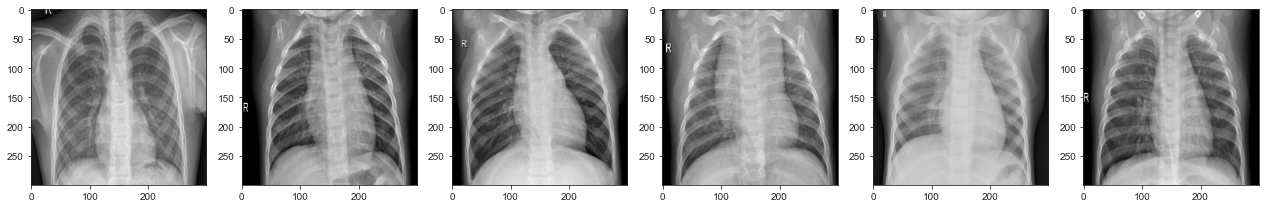

In [35]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 22,4
fig, ax = plt.subplots(1,6)

i = 0
for ele in wrong_predicted_image[0]:
    image = tf.keras.preprocessing.image.array_to_img(ele.reshape(300,300,3))
    ax[i].imshow(image)
    i += 1

print(f'wrong_prediction_by_model --- {wrong_predicted_image[1]}')

### Images On Which Output Predicted Correctly By Model

correct_prediction_by_model --- [1, 0, 1, 1, 1, 1]


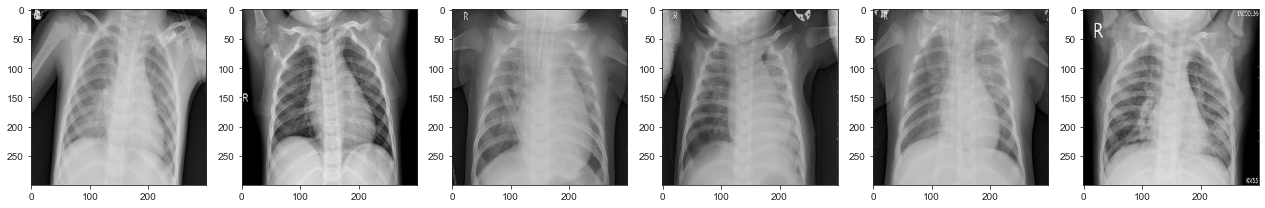

In [36]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 22,4
fig, ax = plt.subplots(1,6)

i = 0
for ele in correct_predicted_image[0]:
    image = tf.keras.preprocessing.image.array_to_img(ele.reshape(300,300,3))
    ax[i].imshow(image)
    i += 1

print(f'correct_prediction_by_model --- {correct_predicted_image[1]}')

##  Residual Net Model

In [37]:
base_model3 = tf.keras.applications.ResNet50(input_shape = (300, 300, 3), include_top = False, weights = 'imagenet')
for layers in base_model3.layers[:100]:
    layers.trainable = False

model3 = tf.keras.Sequential([
        base_model3,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1,activation = tf.nn.sigmoid),
        ])

model3.compile(loss = 'binary_crossentropy', optimizer = RMSprop(lr = 0.001), metrics = ['accuracy'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 10, 10, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 19,454,977
Non-trainable params: 4,134,784
_________________________________________________________________


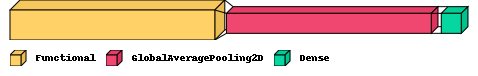

In [38]:
import visualkeras
visualkeras.layered_view(model3, scale_xy = 3, legend = True,)

In [39]:
checkpoint_cb3 = tf.keras.callbacks.ModelCheckpoint("model3_resnet.h5",
                                                    save_best_only = True)

early_stopping_cb3 = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min', restore_best_weights = True)   

### Train The Model

In [40]:
history3 = model3.fit(
    train_generator,
    steps_per_epoch = 10,
    epochs = epochs,
    validation_data = validation_generator,
    class_weight = class_weight,
    callbacks = [checkpoint_cb3, early_stopping_cb3] 
)

Epoch 1/35
10/10 [==============================] - 447s 45s/step - loss: 2.1717 - accuracy: 0.5093 - val_loss: 7905.6841 - val_accuracy: 0.7383
Epoch 2/35
10/10 [==============================] - 443s 44s/step - loss: 0.8234 - accuracy: 0.5254 - val_loss: 70697.2422 - val_accuracy: 0.7383
Epoch 3/35
10/10 [==============================] - 442s 44s/step - loss: 0.7078 - accuracy: 0.4964 - val_loss: 10586.3291 - val_accuracy: 0.7383
Epoch 4/35
10/10 [==============================] - 443s 44s/step - loss: 0.6628 - accuracy: 0.5552 - val_loss: 1285.2543 - val_accuracy: 0.7383
Epoch 5/35
10/10 [==============================] - 438s 44s/step - loss: 0.7132 - accuracy: 0.5842 - val_loss: 337.0464 - val_accuracy: 0.7383
Epoch 6/35
10/10 [==============================] - 450s 45s/step - loss: 0.8692 - accuracy: 0.5422 - val_loss: 29779.3555 - val_accuracy: 0.7383
Epoch 7/35
10/10 [==============================] - 448s 45s/step - loss: 0.6355 - accuracy: 0.6367 - val_loss: 19402.6152 - val

### Visualise The Model Performance

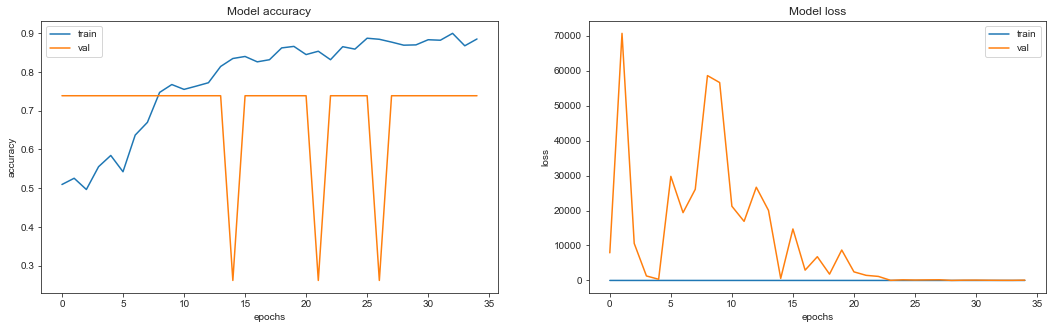

In [41]:
figure, axis = plt.subplots(1, 2, figsize = (18,5))
axis = axis.ravel()

for i,element in enumerate(['accuracy', 'loss']):
    axis[i].plot(history3.history[element])
    axis[i].plot(history3.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('epochs')
    axis[i].set_ylabel(element)
    axis[i].legend(['train', 'val'])

### Predict And Evaluate On Test Dataset

In [42]:
eval_result3 = model3.evaluate_generator(test_generator, 624)
print('loss rate at evaluation data :', eval_result3[0])
print('accuracy rate at evaluation data :', eval_result3[1])

loss rate at evaluation data : 131.0426788330078
accuracy rate at evaluation data : 0.625


In [43]:
predictions = model3.predict_classes(test_generator)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [44]:
print(classification_report(test_generator.classes, predictions, target_names = ['Pneumonia (Class 1)','Normal (Class 0)']))

                     precision    recall  f1-score   support

Pneumonia (Class 1)       0.00      0.00      0.00       234
   Normal (Class 0)       0.62      1.00      0.77       390

           accuracy                           0.62       624
          macro avg       0.31      0.50      0.38       624
       weighted avg       0.39      0.62      0.48       624



C:\Users\ameri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ameri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ameri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
cm = confusion_matrix(test_generator.classes, predictions)
cm

array([[  0, 234],
       [  0, 390]], dtype=int64)

In [46]:
cm = pd.DataFrame(cm, index = ['0','1'], columns = ['0','1'])

<AxesSubplot:>

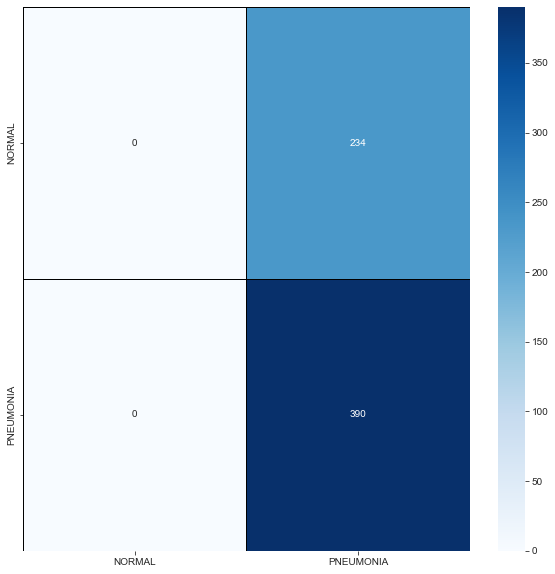

In [47]:
labels = ['NORMAL', 'PNEUMONIA']
plt.figure(figsize = (10,10))
sns.heatmap(cm, cmap = "Blues", linecolor = 'black', linewidth = 1, annot = True, fmt = '', xticklabels = labels, yticklabels = labels)

In [48]:
model3.save('C:/Users/ameri/OneDrive/Documents/MCD/Tetramestre 4/Preprocesamiento de datos/Proyecto Final/')
Residual_model = tf.keras.models.load_model('C:/Users/ameri/OneDrive/Documents/MCD/Tetramestre 4/Preprocesamiento de datos/Proyecto Final/model3_resnet.h5')

wrong_predicted_image = [[],[]]
correct_predicted_image = [[],[]]
i = 0
while i< 5 and len(wrong_predicted_image[0]) < 6:
    j = 0
    while j < 128 and len(wrong_predicted_image[0]) < 6:
        
        image_array = (test_generator[i][0][j]).reshape(1,300,300,3)
        
        prediction = Residual_model.predict(image_array)
        
        if int(round(prediction[0][0])) != test_generator[i][1][j]:
            wrong_predicted_image[0].append(image_array)
            wrong_predicted_image[1].append(int(round(prediction[0][0])))
            
        elif len(correct_predicted_image[0]) < 6:
            correct_predicted_image[0].append(image_array)
            correct_predicted_image[1].append(int(round(prediction[0][0])))
        j += 1
        
    i += 1

INFO:tensorflow:Assets written to: C:/Users/ameri/OneDrive/Documents/MCD/Tetramestre 4/Preprocesamiento de datos/Proyecto Final/assets


### Images On Which Output Predicted Incorrectly By Model

wrong_prediction_by_model --- [1, 1, 1, 1, 1, 1]


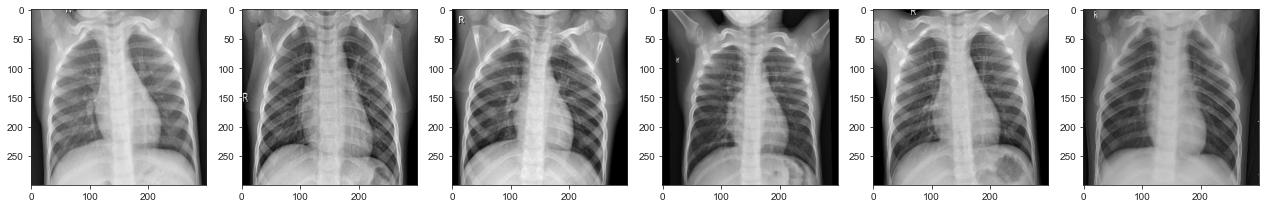

In [49]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 22,4
fig, ax = plt.subplots(1,6)

i = 0
for ele in wrong_predicted_image[0]:
    image = tf.keras.preprocessing.image.array_to_img(ele.reshape(300,300,3))
    ax[i].imshow(image)
    i += 1

print(f'wrong_prediction_by_model --- {wrong_predicted_image[1]}')

### Images On Which Output Predicted Correctly By Model

correct_prediction_by_model --- [1, 1, 1, 1, 1, 1]


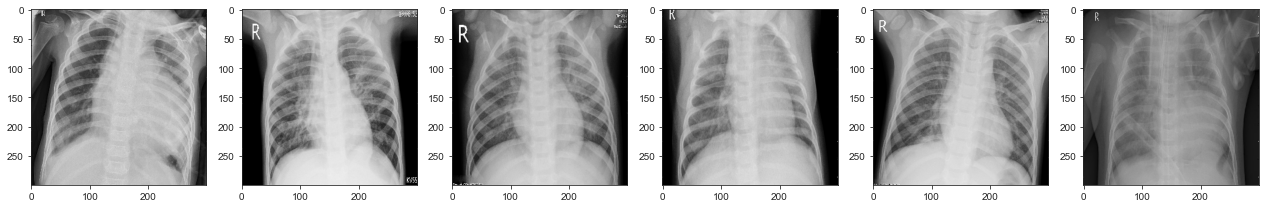

In [50]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 22,4
fig, ax = plt.subplots(1,6)

i = 0
for ele in correct_predicted_image[0]:
    image = tf.keras.preprocessing.image.array_to_img(ele.reshape(300,300,3))
    ax[i].imshow(image)
    i += 1

print(f'correct_prediction_by_model --- {correct_predicted_image[1]}')

## The End